<a href="https://colab.research.google.com/github/tmsk0711/GoingDeeper/blob/main/%082_1ResNet_Ablation_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet Ablation Study

>

In [2]:
# 라이브러리 호출
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteGRL1AG/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteGRL1AG/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# 데이터의 개수도 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [190]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [191]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [239]:
from keras import activations
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [256]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True): # is_50 : resnet 50을 사용할지 안할지를 정하는 bool 변수
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            print(num_cnn)
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), activation=None)
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)

            elif num_cnn != num_cnn:
              
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)

            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            print(x)
            print(shortcut)           
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                print('aaasadfewfewfewfwefewfg32t23')
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])

            x = keras.layers.Activation('relu')(x)
    

    return x

In [258]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='relu',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
    if(is_50==False):    
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dense(num_classes, 
                              activation=activation, 
                              kernel_initializer='he_normal'
                              )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

In [259]:
resnet_50 = build_resnet(is_50=True)

resnet_50.summary()

3
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 256), dtype=tf.float32, name=None), name='batch_normalization_1842/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1842'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 256), dtype=tf.float32, name=None), name='batch_normalization_1839/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1839'")
3
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 256), dtype=tf.float32, name=None), name='batch_normalization_1845/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1845'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 256), dtype=tf.float32, name=None), name='activation_1270/Relu:0', description="created by layer 'activation_1270'")
3
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 256), dtype=tf.float32, name=None), name='batch_normalization_1848/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1848'")
KerasTensor(type_spec=TensorS

In [236]:
resnet_34 = build_resnet(is_50=False,name='ResNet34')

resnet_34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_111 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_925 (Conv2D)            (None, 16, 16, 64)   9472        ['input_111[0][0]']              
                                                                                                  
 batch_normalization_1702 (Batc  (None, 16, 16, 64)  256         ['conv2d_925[0][0]']             
 hNormalization)                                                                                  
                                                                                                  
 activation_1151 (Activation)   (None, 16, 16, 64)   0           ['batch_normalization_1702

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
BATCH_SIZE = 256
EPOCH = 15
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)


In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 35s 79ms/step - loss: 2.1185 - accuracy: 0.3136 - val_loss: 3.4705 - val_accuracy: 0.1052
Epoch 2/15
195/195 [==============================] - 13s 67ms/step - loss: 1.5762 - accuracy: 0.4376 - val_loss: 2.5227 - val_accuracy: 0.2349
Epoch 3/15
195/195 [==============================] - 13s 66ms/step - loss: 1.3843 - accuracy: 0.5069 - val_loss: 1.7252 - val_accuracy: 0.3932
Epoch 4/15
195/195 [==============================] - 13s 66ms/step - loss: 1.2622 - accuracy: 0.5470 - val_loss: 1.5106 - val_accuracy: 0.4784
Epoch 5/15
195/195 [==============================] - 13s 68ms/step - loss: 1.1416 - accuracy: 0.5925 - val_loss: 1.4577 - val_accuracy: 0.4849
Epoch 6/15
195/195 [==============================] - 13s 66ms/step - loss: 1.0292 - accuracy: 0.6358 - val_loss: 1.3986 - val_accuracy: 0.5113
Epoch 7/15
195/195 [==============================] - 13s 67ms/step - loss: 0.9350 - accuracy: 0.6694 - val_loss: 1.3643 - val_accuracy: 0.5312
Epo

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

histoty_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 20s 70ms/step - loss: 2.0056 - accuracy: 0.3216 - val_loss: 2.8989 - val_accuracy: 0.1500
Epoch 2/15
195/195 [==============================] - 15s 76ms/step - loss: 1.5532 - accuracy: 0.4509 - val_loss: 2.4129 - val_accuracy: 0.2340
Epoch 3/15
195/195 [==============================] - 13s 67ms/step - loss: 1.3723 - accuracy: 0.5123 - val_loss: 1.6665 - val_accuracy: 0.4072
Epoch 4/15
195/195 [==============================] - 13s 67ms/step - loss: 1.2526 - accuracy: 0.5527 - val_loss: 1.4902 - val_accuracy: 0.4718
Epoch 5/15
195/195 [==============================] - 13s 66ms/step - loss: 1.1335 - accuracy: 0.5990 - val_loss: 1.3790 - val_accuracy: 0.5272
Epoch 6/15
195/195 [==============================] - 13s 66ms/step - loss: 1.0221 - accuracy: 0.6390 - val_loss: 1.4174 - val_accuracy: 0.5088
Epoch 7/15
195/195 [==============================] - 13s 66ms/step - loss: 0.9200 - accuracy: 0.6782 - val_loss: 1.3965 - val_accuracy: 0.5246
Epo

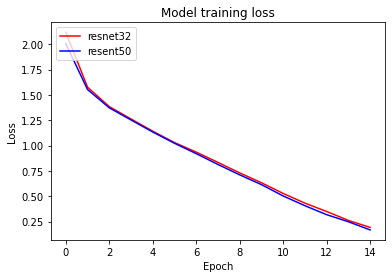

In [ ]:
import matplotlib.pyplot as plt

plt.plot(histoty_34.history['loss'], 'r')
plt.plot(histoty_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet32', 'resent50'], loc='upper left')
plt.show()

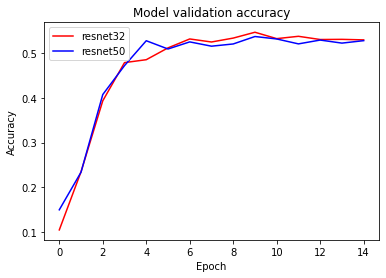

In [ ]:
plt.plot(histoty_34.history['val_accuracy'], 'r')
plt.plot(histoty_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet32', 'resnet50'], loc='upper left')
plt.show()

AttributeError: ignored


# 회고

> 1. 처음에는 모델을 구현한다는게 엄청 막연했지만.. 많은 참고자료들과 블로그를 보면서 만들어봤는데 해봤다는 것에 만족한다.
2. 직접만들어보니 모델의 프로세스들을 더 이해하기 좋은것 같다. 
3. 너무 어렵다.. 점점 더 어려워진다..

